# Study of the Live Time signals in RGD Data
#### Maurik Holtrop, UNH, December 13, 2023

This is a relatively quick look at the three live time signals that can be obtained from MYA for the Run Group D dataset.

The total data set runs from October 4, 2023, until mid-December, 2023. As of this writing the data is still being accumulated. The data is retrieved from MYA using the 
["Run Data"](https://github.com/mholtrop/RunData) package, which includes the Mya Python class. This package queries the MYA database though the web "interval" interface, 
which can be checked from the ["Epics myquery interval page"](https://epicsweb.jlab.org/myquery/interval-form.html). When off-site this requires a CUE username and password.

Three channels from MYA are inspected: `B_DAQ:livetime` the DAQ based live-time, 
`B_DET_TRIG_DISC_00:cTrg:livetime` the trigger based live-time (note that the channel B_DET_TRIG_DISC_07:cTrg:livetime is not persisted in MYA), and the `B_DAQ:livetime_pulser` the pulser based live-time.

The data is retrieved from MYA as a single large dataset. It is not split over runs or periods when the DAQ was running. An attempt is made to filter such periods out of the data. 

Note that there are several time spans where the Trigger and Clock based live-times are not recorded: November 4th 2:18 until November 5th 10:54, and on December 6th at 00:45 the recording of the Trigger and Clock based livetimes stopped. It is thus questionable whether any live-time measure apart from the DAQ based one is usable for normalization.

In [2]:
import ROOT as R
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
from pandas import HDFStore
import sqlalchemy as sql
from RunData.RunData import RunData
import RGD2023 as RGD
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default="plotly_white"
pio.renderers.default = 'jupyterlab'  # Alternate: 'browser' opens new browser window with plots.


Welcome to JupyROOT 6.31/01
RGD setup.


In [3]:
data = RunData(sqlcache=False, i_am_at_jlab=False)  # Start the data store without backend cache. The cache is not reliable enough for multiple runs with different requests.
data.debug = 0
run_sub_periods = [
    # (datetime(2023, 2, 20,  0, 0),  datetime(2023, 2, 25, 0, 0)),
    #(datetime(2023, 10, 4, 6, 0), datetime(2023, 10, 31,0,0)),
    #(datetime(2023, 10, 31, 0, 0), datetime.now())
    (datetime(2023, 10, 4, 6, 0), datetime.now()),
    (datetime(2023, 11, 10, 0, 0), datetime(2023, 11, 10, 3, 0) )  # 5am to noon on Dec 11.
]
Excluded_runs = [18829, 18963, 18964, 18977, 18983]   # Explicitly exclude these runs from all further processing.

RGD.setup_rundata_structures(data, run_sub_periods[1], "IPM2C21A")
data.All_Runs['luminosity'] *= 1E-3   # Rescale luminosity from 1/pb to 1/fb

for r in Excluded_runs:
    if r in data.All_Runs.index:
        data.All_Runs.drop(r, inplace=True)
        

Fetching the data from 2023-11-10 00:00:00 to 2023-11-10 03:00:00


In [4]:
# To check the data sample, make a table of the runs in the requested run period.
data.All_Runs

,start_time,end_time,is_valid_run_end,user_comment,run_type,target,beam_current_request,operators,event_count,events_rate,...,run_start_time,run_end_time,beam_energy,selected,IPM2C21A,B_DAQ:livetime,IPM2C21A_corr,charge,IPM2C21A_lumi,luminosity
number,,,,,,,,,,,,,,,,,,,,,
18747,2023-11-10 00:21:17,2023-11-10 02:45:54,True,Production,PROD67,CuSn,95 nA,"expert: Rhidian Williams, worker: Mikhail Yurov",70200413,895.462,...,2023-11-10 00:21:17,2023-11-10 02:45:54,10532.2,True,0.675862,8.357315e+08,0.647783,0.647783,507.249824,0.50725


In [5]:
# Get the time span that we want to plot, from the start of the first run to the end of the last run.
start_time = data.All_Runs['start_time'].iloc[0]
end_time = data.All_Runs['end_time'].iloc[-1]
print(f"start_time: {start_time}   end_time = {end_time}   Duration: {(end_time - start_time).total_seconds()/3600:6.2f} hours.")

start_time: 2023-11-10 00:21:17   end_time = 2023-11-10 02:45:54   Duration:   2.41 hours.


In [6]:
# Get the data from MYA.
# For large timespans of multiple days, this can take some time.

# current_IPM2C21A = data.Mya.get("IPM2C21A", start_time, end_time,
#                                 do_not_clean=True, run_number=1)
# current_scalerS2b = data.Mya.get("scalerS2b", start_time, end_time,
#                                  do_not_clean=True, run_number=1)
# current_FCup = data.Mya.get("scaler_calc1b", start_time, end_time,
#                             do_not_clean=True, run_number=1)
#
# FCup_offset = data.Mya.get("fcup_offset", start_time, end_time,
#                            do_not_clean=True, run_number=1)
# FCup_slope = data.Mya.get("fcup_slope", start_time, end_time,
#                           do_not_clean=True, run_number=1)
# FCup_beam_stop = data.Mya.get("beam_stop", start_time, end_time,
#                               do_not_clean=True, run_number=1)
# FCup_beam_atten = data.Mya.get("beam_stop_atten", start_time, end_time,
#                                do_not_clean=True, run_number=1)

# From Eugene, different live times:
# B_DAQ:livetime                     DAQ based
# B_DET_TRIG_DISC_07:cTrg:livetime   Trigger based, see note below.
# B_DAQ:livetime_pulser              clock based
# Note: the DISC_07 is not stored in MYA, but the DISC_00 is.
#
LT_DAQ = data.Mya.get("B_DAQ:livetime", start_time, end_time,
                      do_not_clean=True, run_number=1)
LT_Trigger = data.Mya.get("B_DET_TRIG_DISC_00:cTrg:livetime", start_time, end_time,
                          do_not_clean=True, run_number=1)
LT_clock = data.Mya.get("B_DAQ:livetime_pulser", start_time, end_time,
                        do_not_clean=True, run_number=1)
print(f"Fetched: LT_DAQ: {len(LT_DAQ)}  LT_Trigger: {len(LT_Trigger)}  LT_clock: {len(LT_clock)}")

Fetched: LT_DAQ: 5182  LT_Trigger: 3702  LT_clock: 3025


In [7]:
# Plot the data with Plotly. This gives a zoomable interactive graph of the data
LT_DAQ_plot = LT_DAQ.loc[LT_DAQ.value > 80]
LT_Trig_plot = LT_Trigger.loc[LT_Trigger.value > 80]
LT_Clock_plot = LT_clock.loc[LT_clock.value > 80]
plot_start = datetime(2023,11,10,0,0)
plot_end = datetime(2023,11,10,2,0)
fig = make_subplots() # (specs=[[{"secondary_y": True}]])
fig.update_layout(width=1280, height=800,
                  title=go.layout.Title(text=f"Livetime value for RGD run", xanchor="left", x=0.4),
                  titlefont=dict(size=24),)
fig.add_trace(go.Scatter(x=LT_DAQ_plot.loc[ (LT_DAQ_plot.time>plot_start) & (LT_DAQ_plot.time<plot_end)].time, y=LT_DAQ_plot.loc[ (LT_DAQ_plot.time>plot_start) & (LT_DAQ_plot.time<plot_end)].value, line_shape='hv', name="DAQ Live time", line=dict(color="red")))
fig.add_trace(go.Scatter(x=LT_Trig_plot.loc[ (LT_Trig_plot.time>plot_start) & (LT_Trig_plot.time<plot_end)].time, y=LT_Trig_plot.loc[ (LT_Trig_plot.time>plot_start) & (LT_Trig_plot.time<plot_end)].value, line_shape='hv', name="Trigger Live Time", line=dict(color="green")))
fig.add_trace(go.Scatter(x=LT_Clock_plot.loc[ (LT_Clock_plot.time>plot_start) & (LT_Clock_plot.time<plot_end)].time, y=LT_Clock_plot.loc[ (LT_Clock_plot.time>plot_start) & (LT_Clock_plot.time<plot_end)].value, line_shape='hv', name="Clock Live Time", line=dict(color="blue")))
fig.update_xaxes(title_text="Date", titlefont=dict(size=22), tickfont=dict(size=18))
fig.update_yaxes(title_text="Value", titlefont=dict(size=22), tickfont=dict(size=18))
#fig.update_yaxes(title_text="Livetime", titlefont=dict(size=22),range=[0., 110.], tickfont=dict(size=18), secondary_y=True)
#fig.write_image("Livetime_plots_Nov7_2023_1minute.pdf",width=2048, height=1024)
fig.show()

In [8]:
# Convert to ROOT Dataframes to make histograms in a more familiar environment than Numpy and Matplotlib
rd_DAQ = R.RDF.FromNumpy({"value": LT_DAQ_plot.value.to_numpy(), "ms":LT_DAQ_plot.ms.to_numpy()})
rd_Trigger = R.RDF.FromNumpy({"value": LT_Trig_plot.value.to_numpy(), "ms":LT_Trig_plot.ms.to_numpy()})
rd_Clock = R.RDF.FromNumpy({"value": LT_Clock_plot.value.to_numpy(), "ms":LT_Clock_plot.ms.to_numpy()})

In [9]:
hist_DAQ = rd_DAQ.Histo1D(("hist_DAQ","DAQ LT values",200,85.,100.),"value")
hist_Trig = rd_Trigger.Histo1D(("hist_Trig","Trigger LT values",200,85.,100.),"value")
hist_Clock = rd_Clock.Histo1D(("hist_Clock","Clock LT values",200,85.,100.),"value")


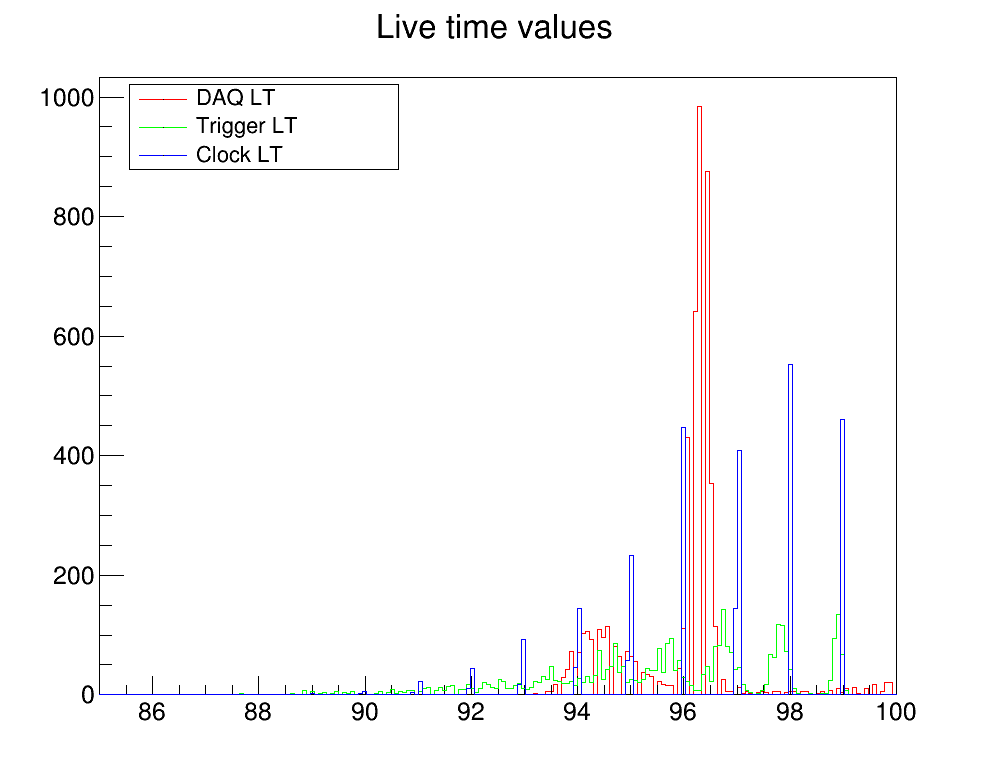

In [10]:
cc = R.TCanvas("cc","CC",1000,800)
hist_DAQ.SetLineColor(R.kRed)
hist_DAQ.SetStats(0)
hist_DAQ.SetTitle("Live time values")
hist_DAQ.Draw()
hist_Trig.SetLineColor(R.kGreen)
hist_Trig.Draw("same")
hist_Clock.SetLineColor(R.kBlue)
hist_Clock.Draw("same")
leg = R.TLegend(0.13,0.78,0.4,0.89)
leg.AddEntry(hist_DAQ.GetPtr(),"DAQ LT")
leg.AddEntry(hist_Trig.GetPtr(),"Trigger LT")
leg.AddEntry(hist_Clock.GetPtr(),"Clock LT")
leg.Draw()
cc.Draw()
# cc.SaveAs("LiveTimeHist_Nov1_Nov15.pdf")